### Settings, imports, data

In [43]:
%matplotlib inline
from collections import OrderedDict
from IPython.display import display, Markdown
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import learn
from monitoring.data import get_production_data

sns.set()
pd.options.display.float_format = '{:.2f}'.format

In [3]:
# Load data from local cache, fetch and store if not available.
data = get_production_data('2018-01-13')

Fetching https://robomise.cz/media/exports/robomission-latest.zip ...
Stored at: /home/xeffenb1/projects/robomission/.prodcache/
Data loaded from cache (/home/xeffenb1/projects/robomission/.prodcache/robomission-2018-01-13/).


# All task sessions

### Histogram of log-times

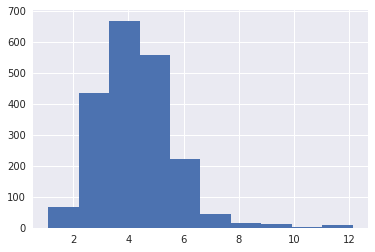

In [4]:
ts = data['task_sessions']
ts.time_spent[ts.time_spent > 0].apply(np.log).hist()

# All tasks

In [196]:
ts = data['task_sessions']
grouped_ts = ts.groupby('task')
metrics = pd.DataFrame(OrderedDict(
    time=grouped_ts.time_spent.median(),
    success=grouped_ts.solved.mean(),
    n_attempts=grouped_ts.task.count(),
    n_solved=grouped_ts.solved.sum(),
))
metrics['n_unsolved'] = metrics.n_attempts - metrics.n_solved
tasks = data['tasks'].join(metrics)

### Solved and Unsolved Attempts

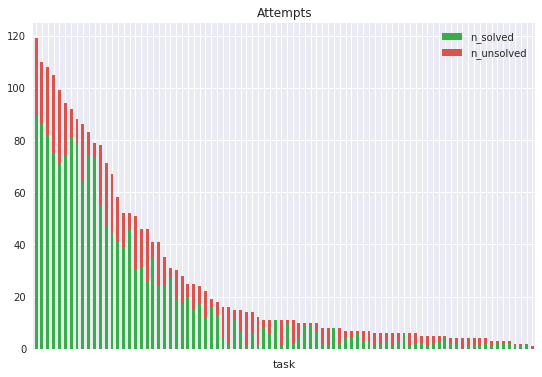

In [219]:
ordered_tasks = tasks.sort_values('n_attempts', ascending=False)
ax = ordered_tasks[['n_solved', 'n_unsolved']].plot.bar(
    title='Attempts',
    stacked=True,
    color=[sns.xkcd_rgb["medium green"], sns.xkcd_rgb["pale red"]],
    figsize=(9,6))
ax.set_xticklabels([])
ax.set_xlabel('task');

### Success rate distribution

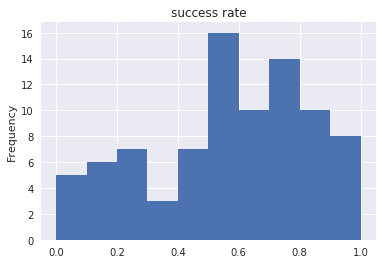

In [7]:
ax = tasks.success.plot.hist(title='success rate')

### Median time distribution

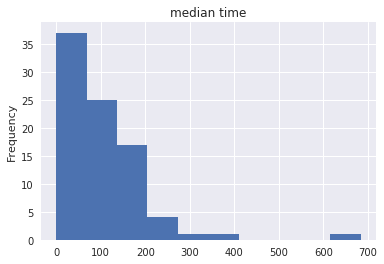

In [8]:
ax = tasks.time.plot.hist(title='median time')

### Median Time vs Success Rate

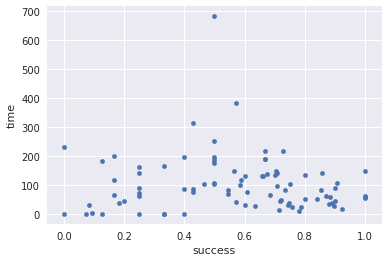

In [11]:
tasks.plot.scatter(x='success', y='time')

# Levels Overview

In [185]:
VIRIDIS = sns.color_palette('viridis', n_colors=256)

def viridis_background(value, vmin, vmax, reverse=False):
    norm_value = (value - vmin) / (vmax - vmin)
    if reverse:
        norm_value = 1 - norm_value
    max_index = len(VIRIDIS) - 1
    soft_index = norm_value * max_index
    index = max(0, min(max_index, int(soft_index)))
    color = (int(255*c) for c in VIRIDIS[index])
    return 'background-color: rgba({0}, {1}, {2}, 0.6);'.format(*color)

def percentage_background(value):
    return viridis_background(value, vmin=0, vmax=1)
    
def time_background(value):
    return viridis_background(value, vmin=0, vmax=300, reverse=True)

def style_level(df, order_by='id'):
    df = df[['name', 'n_attempts', 'success', 'time']]
    df = df.reset_index()
    df = df.sort_values(by=order_by)
    styled_df = (
        df.style
        .set_table_styles(
            [{'selector': 'tr',
              'props': [('background-color', 'white')]},
             # workaround to hide index column
             {'selector': '.row_heading, .blank',
              'props': [('display', 'none;')]},            
            ])
        #.bar(subset=['n_attempts'], align='mid', color='#d65f5f')
        .applymap(percentage_background, subset=['success'])
        .applymap(time_background, subset=['time'])
        .format({
           'success': '{:.0%}'.format,
           'time': '{:.0f}s'.format,
        }))
    return styled_df

def display_level_overview(df, order_by='id'):
    styled = style_level(df, order_by=order_by)
    display(styled)    

In [186]:
grouped_tasks = tasks.groupby('level')
metrics = pd.DataFrame(OrderedDict(
    time=grouped_tasks.time.median(), # median of medians
    success=grouped_tasks.success.mean(),
    n_attempts=grouped_tasks.n_attempts.sum(),
    n_solved=grouped_tasks.n_solved.sum(),
))
levels = data['levels'].merge(metrics, left_on='name', right_index=True)
display_level_overview(levels)

,id,name,n_attempts,success,time
0,1,moves,886,74%,30s
1,2,world,490,78%,96s
2,3,repeat,388,76%,90s
3,4,while,179,78%,64s
4,5,loops,142,65%,81s
5,6,if,56,27%,118s
6,7,comparing,42,41%,134s
7,8,if-else,30,49%,85s
8,9,final-challenge,105,32%,118s


# Tasks in Levels

# moves

,id,name,n_attempts,success,time
8,51,one-step-forward,110,78%,11s
2,25,three-steps-forward,105,71%,15s
7,49,turning-right,94,79%,22s
5,44,turning-left,108,76%,23s
10,67,plus,30,63%,26s
6,86,diamond-path,25,60%,30s
3,26,turning-right-and-left,86,74%,32s
1,14,beware-of-asteroid,92,88%,36s
0,2,turning-left-and-right,119,75%,38s
4,31,diamond-on-right,99,72%,45s


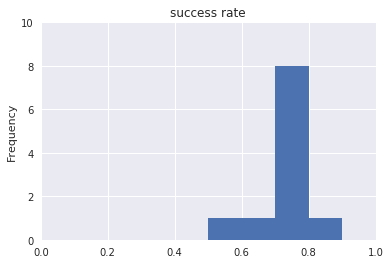

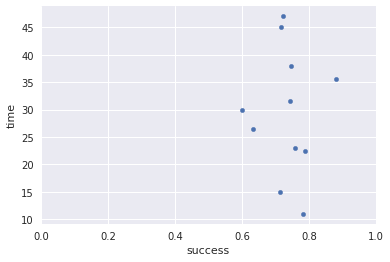

-----

# world

,id,name,n_attempts,success,time
1,10,shot,79,92%,17s
2,12,wormhole-demo,88,90%,26s
3,8,shooting,83,89%,37s
6,79,last-shot,24,71%,96s
4,19,2diamonds-2meteorids,67,66%,132s
5,23,dont-forget-shot,71,66%,132s
0,6,tunnel,78,71%,147s


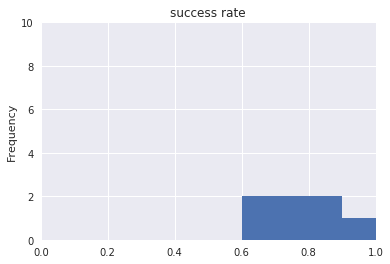

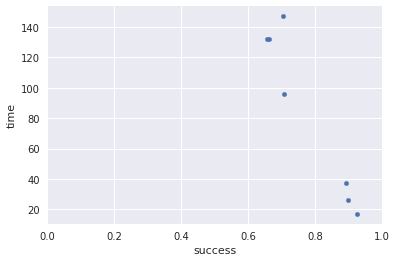

-----

# repeat

,id,name,n_attempts,success,time
9,71,big-left-turn,10,90%,45s
8,70,big-right-turn,11,100%,55s
0,11,ladder,52,88%,59s
7,84,triangle,11,55%,70s
3,1,diamonds-in-meteoroid-cloud,41,85%,84s
10,76,blocked-wormhole,10,90%,90s
1,13,n,52,75%,102s
4,46,find-the-path,51,59%,116s
5,57,stairs,46,67%,137s
2,21,steal-the-nose,58,71%,140s


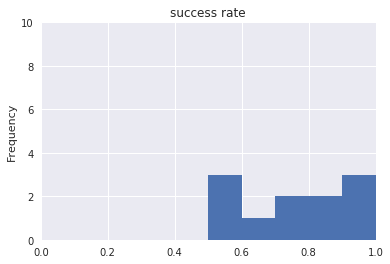

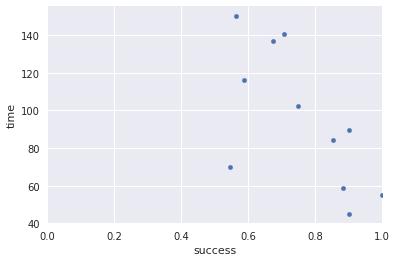

-----

# while

,id,name,n_attempts,success,time
4,53,direct-flight-ahead,25,80%,52s
3,41,yellow-hint,31,87%,61s
5,73,stop-on-red,8,100%,61s
0,3,zig-zag,35,69%,64s
1,17,yellow-is-not-red,28,61%,76s
2,38,direction-change,41,59%,100s
6,69,diamond-in-house,11,91%,107s


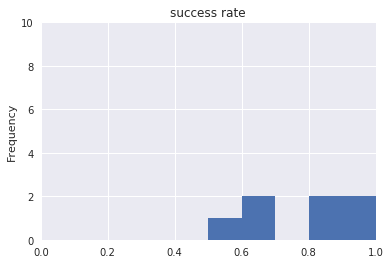

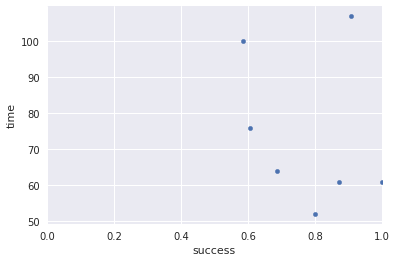

-----

# loops

,id,name,n_attempts,success,time
9,72,four-vs,7,57%,42s
3,56,diamond-cross,19,84%,51s
8,68,stripes,6,100%,60s
4,55,color-slalom,14,43%,76s
0,37,big-slalom,22,55%,81s
1,50,double-bend,15,73%,81s
2,47,arrow,15,47%,104s
6,58,collect-diamonds,10,70%,133s
7,63,rectangle,7,86%,140s
10,32,double-track,16,25%,164s


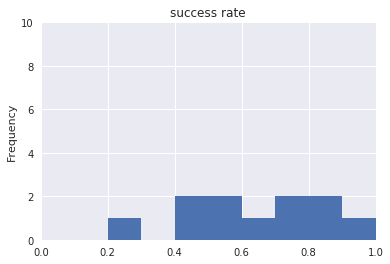

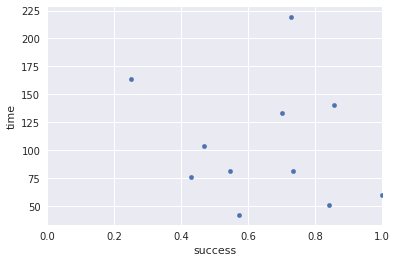

-----

# if

,id,name,n_attempts,success,time
2,59,two-diamonds,12,8%,30s
4,34,follow-colors,7,43%,85s
3,60,red-shooting,8,25%,90s
5,78,yellow-squares,6,17%,118s
0,5,diamonds-with-signals,10,40%,196s
6,81,belgian-flag,6,17%,200s
1,27,on-yellow-to-left,7,43%,315s


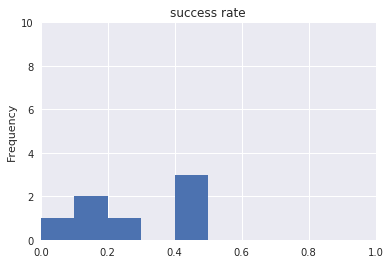

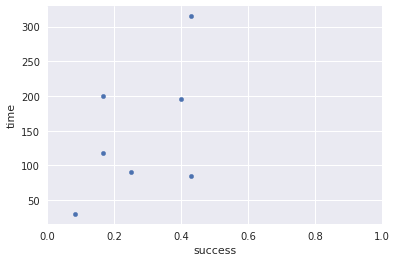

-----

# comparing

,id,name,n_attempts,success,time
0,9,diamond-lines,5,40%,0s
5,64,wave,3,33%,0s
2,85,chessboard,4,25%,62s
4,83,maneuvers-on-left,2,50%,104s
6,7,meteoroids-and-wormholes,5,80%,134s
8,82,free-column,6,33%,164s
3,48,edge-to-edge,6,50%,197s
7,65,letter-h,4,0%,232s
1,28,slalom-position-testing,7,57%,383s


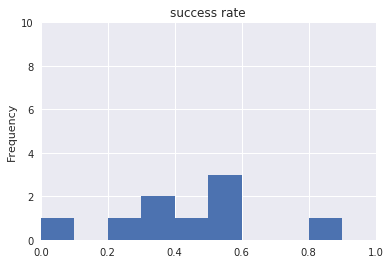

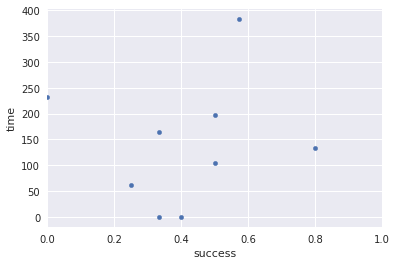

-----

# if-else

,id,name,n_attempts,success,time
0,43,colorful-flowers,8,25%,0s
3,29,color-navigation,6,33%,0s
1,75,bouncing-from-edge,4,25%,73s
5,24,narrow-passage,5,40%,85s
6,80,letter-e,2,100%,148s
4,16,diamonds-on-yellow,2,50%,174s
2,22,triple-steps,3,67%,219s


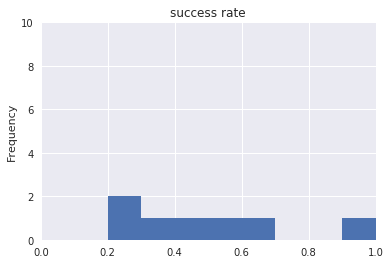

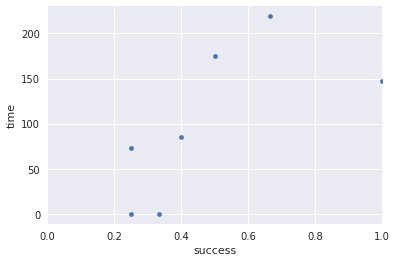

-----

# final-challenge

,id,name,n_attempts,success,time
9,62,two-bit-instructions,8,12%,0s
12,33,diamond-ring,14,7%,0s
13,74,turning-in-square,1,0%,0s
15,61,mirror,11,9%,3s
2,4,triple-slalom,11,18%,39s
11,45,diagonal-lines,5,20%,46s
7,40,plan-your-shooting,6,17%,65s
3,20,five-diamonds,6,50%,106s
6,36,cross-2,5,60%,131s
5,35,six-diamonds,4,25%,140s


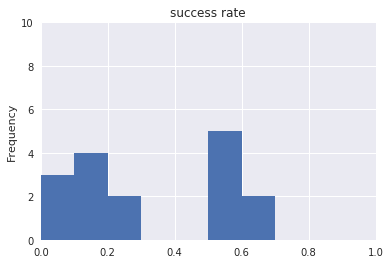

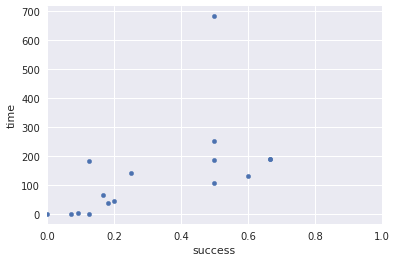

-----

In [188]:
def display_plot(ax):
    display(ax)
    plt.show()  # forcing to display here

def display_success_rate_hist(tasks):
    ax = tasks.success.plot.hist(
        bins=np.linspace(0, 1, 11),
        title='success rate')
    #plt.xticks(np.linspace(0, 1, 11))
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 10)
    #plt.yticks(range(10))
    display_plot(ax)
    
def display_time_vs_success(tasks):
    ax = tasks.plot.scatter(x='success', y='time')
    ax.set_xlim(0, 1)
    display_plot(ax)
    
def analyze_level(name):
    ts = tasks[tasks.level == name]
    ts = ts[['name', 'n_attempts', 'success', 'time']]
    display(Markdown('# {name}'.format(name=name)))
    display_level_overview(ts, order_by='time')
    display_success_rate_hist(ts)
    display_time_vs_success(ts)
    display(Markdown('-----'))

for name in levels.name:
    analyze_level(name)